In [4]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import yfinance as yf
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly
import seaborn as sns
from pandas_datareader.data import DataReader

In [6]:
data = yf.download('NVDA', start='2014-01-01', end=datetime.now(), interval='1d')

data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2014-01-02,0.373992,0.396500,0.399500,0.393000,0.398000,260092000
2014-01-03,0.369512,0.391750,0.398000,0.390500,0.397250,259332000
2014-01-06,0.374464,0.397000,0.400000,0.392000,0.395750,409492000
2014-01-07,0.380595,0.403500,0.405000,0.398250,0.401000,333288000
2014-01-08,0.385782,0.409000,0.411000,0.403500,0.405000,308192000
...,...,...,...,...,...,...
2024-11-22,141.949997,141.949997,147.160004,141.100006,145.929993,236406200
2024-11-25,136.020004,136.020004,142.050003,135.820007,141.990005,344941900


In [7]:
print(data.isnull().sum())  # Count missing values per column
print(data.shape)          # Check the dimensions of the DataFrame

Price      Ticker
Adj Close  NVDA      0
Close      NVDA      0
High       NVDA      0
Low        NVDA      0
Open       NVDA      0
Volume     NVDA      0
dtype: int64
(2747, 6)


In [10]:
# Reset index to remove multi-index structure
data.reset_index(inplace=True)

# Drop the first row that contains the 'Ticker' values (Row 0)
data.drop(index=0, inplace=True)

# Flatten the column names (remove multi-level columns)
data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']  # Assign the proper column names

# Reset index to make it a clean sequential index
data.reset_index(drop=True, inplace=True)

# Display the result to verify
data

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-01-03,0.369512,0.391750,0.398000,0.390500,0.397250,259332000
1,2014-01-06,0.374464,0.397000,0.400000,0.392000,0.395750,409492000
2,2014-01-07,0.380595,0.403500,0.405000,0.398250,0.401000,333288000
3,2014-01-08,0.385782,0.409000,0.411000,0.403500,0.405000,308192000
4,2014-01-09,0.371398,0.393750,0.403500,0.392500,0.402750,292172000
...,...,...,...,...,...,...,...
2741,2024-11-22,141.949997,141.949997,147.160004,141.100006,145.929993,236406200
2742,2024-11-25,136.020004,136.020004,142.050003,135.820007,141.990005,344941900
2743,2024-11-26,136.919998,136.919998,139.300003,135.669998,137.699997,190287700
2744,2024-11-27,135.339996,135.339996,137.220001,131.800003,135.009995,226370900


In [12]:
data['RSI'] = ta.rsi(data.Close, length = 14)
data['EMAF'] = ta.ema(data.Close, length = 20)
data['EMAM'] = ta.ema(data.Close, length = 100)
data['EMAS'] = ta.ema(data.Close, length = 150)

data['Target'] = data['Adj Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.drop(['Volume', 'Close'], axis=1, inplace=True)
data = data.iloc[:, 0:12]
pd.set_option('display.max_columns', None)

# Drop the 'index' column
# data.drop(columns=['index']], inplace=True)
# Reset the index to ensure it's sequential
data.reset_index(drop=True, inplace=True)

data

,Date,Adj Close,High,Low,Open,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,2014-08-07,0.415485,0.448750,0.433500,0.444750,33.995494,0.451503,0.455589,0.450280,-0.003368,0,0.452132
1,2014-08-08,0.452132,0.477500,0.455500,0.455500,60.502216,0.453741,0.455973,0.450607,-0.025748,0,0.449752
2,2014-08-11,0.449752,0.477500,0.471250,0.475500,58.849534,0.455528,0.456301,0.450897,-0.022498,0,0.449752
3,2014-08-12,0.449752,0.475000,0.467250,0.472250,58.849534,0.457144,0.456621,0.451184,-0.020880,0,0.452370
4,2014-08-13,0.452370,0.479250,0.470250,0.473250,60.235268,0.458869,0.456990,0.451502,-0.029628,0,0.447372
...,...,...,...,...,...,...,...,...,...,...,...,...
2591,2024-11-21,146.669998,152.889999,140.699997,149.350006,58.347140,142.710050,126.470569,118.105766,-3.979996,0,141.949997
2592,2024-11-22,141.949997,147.160004,141.100006,145.929993,51.307666,142.637664,126.777093,118.421584,-5.970001,0,136.020004
2593,2024-11-25,136.020004,142.050003,135.820007,141.990005,44.107680,142.007411,126.960120,118.654675,-0.779999,0,136.919998
2594,2024-11-26,136.919998,139.300003,135.669998,137.699997,45.360888,141.522895,127.157346,118.896600,0.330002,1,135.339996


In [14]:
data.columns

Index(['Date', 'Adj Close', 'High', 'Low', 'Open', 'RSI', 'EMAF', 'EMAM',
       'EMAS', 'Target', 'TargetClass', 'TargetNextClose'],
      dtype='object')

In [16]:
data_set = data.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set
#print(data_set.shape)
#print(data.shape)
#print(type(data_set))

,Date,Adj Close,High,Low,Open,RSI,EMAF,EMAM,EMAS,Target,TargetClass
0,2014-08-07,0.415485,0.448750,0.433500,0.444750,33.995494,0.451503,0.455589,0.450280,-0.003368,0
1,2014-08-08,0.452132,0.477500,0.455500,0.455500,60.502216,0.453741,0.455973,0.450607,-0.025748,0
2,2014-08-11,0.449752,0.477500,0.471250,0.475500,58.849534,0.455528,0.456301,0.450897,-0.022498,0
3,2014-08-12,0.449752,0.475000,0.467250,0.472250,58.849534,0.457144,0.456621,0.451184,-0.020880,0
4,2014-08-13,0.452370,0.479250,0.470250,0.473250,60.235268,0.458869,0.456990,0.451502,-0.029628,0
...,...,...,...,...,...,...,...,...,...,...,...
2591,2024-11-21,146.669998,152.889999,140.699997,149.350006,58.347140,142.710050,126.470569,118.105766,-3.979996,0
2592,2024-11-22,141.949997,147.160004,141.100006,145.929993,51.307666,142.637664,126.777093,118.421584,-5.970001,0
2593,2024-11-25,136.020004,142.050003,135.820007,141.990005,44.107680,142.007411,126.960120,118.654675,-0.779999,0
2594,2024-11-26,136.919998,139.300003,135.669998,137.699997,45.360888,141.522895,127.157346,118.896600,0.330002,1


In [18]:
data_set.dtypes

Date           datetime64[ns]
Adj Close             float64
High                  float64
Low                   float64
Open                  float64
RSI                   float64
EMAF                  float64
EMAM                  float64
EMAS                  float64
Target                float64
TargetClass             int64
dtype: object

In [22]:
from sklearn.preprocessing import MinMaxScaler
numeric_columns = data_set.select_dtypes(include=['float64', 'int64']).columns

# Apply MinMaxScaler only to numeric columns
sc = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = sc.fit_transform(data_set[numeric_columns])

# Convert the scaled data back to a DataFrame
data_set_scaled_df = pd.DataFrame(data_set_scaled, columns=numeric_columns)

# If you want to add back the 'Date' column
data_set_scaled_df['Date'] = data_set['Date'].values

# Display the result
data_set_scaled_df

,Adj Close,High,Low,Open,RSI,EMAF,EMAM,EMAS,Target,TargetClass,Date
0,0.000095,0.000107,0.000098,0.000144,0.215609,0.000027,0.000000,0.000000,0.518465,0.0,2014-08-07
1,0.000342,0.000295,0.000249,0.000217,0.592445,0.000043,0.000003,0.000003,0.517180,0.0,2014-08-08
2,0.000326,0.000295,0.000357,0.000351,0.568949,0.000055,0.000006,0.000005,0.517366,0.0,2014-08-11
3,0.000326,0.000279,0.000329,0.000329,0.568949,0.000067,0.000008,0.000008,0.517459,0.0,2014-08-12
4,0.000344,0.000307,0.000350,0.000336,0.588650,0.000079,0.000011,0.000010,0.516957,0.0,2014-08-13
...,...,...,...,...,...,...,...,...,...,...,...
2591,0.985116,1.000000,0.961876,1.000000,0.561807,1.000000,0.993309,0.991500,0.290088,0.0,2024-11-21
2592,0.953327,0.962416,0.964619,0.977036,0.461729,0.999491,0.995725,0.994162,0.175803,0.0,2024-11-22
2593,0.913388,0.928898,0.928415,0.950580,0.359370,0.995061,0.997168,0.996126,0.473863,0.0,2024-11-25
2594,0.919450,0.910860,0.927387,0.921774,0.377186,0.991655,0.998723,0.998165,0.537610,1.0,2024-11-26


In [24]:
# multiple feature from data provided to the model
X = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
backcandles = 30
print(data_set_scaled.shape[0])
for j in range(8):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(y)
print(y.shape)

2596
[[[9.54764562e-05 1.06586980e-04 9.77091861e-05 ... 2.71914158e-05
   0.00000000e+00 0.00000000e+00]
  [3.42288941e-04 2.95164141e-04 2.48558764e-04 ... 4.29212857e-05
   3.02983599e-06 2.75919248e-06]
  [3.26262425e-04 2.95164141e-04 3.56553214e-04 ... 5.54794401e-05
   5.60945432e-06 5.20279501e-06]
  ...
  [3.78296517e-04 3.18121454e-04 3.39411244e-04 ... 2.41298572e-04
   9.01426599e-05 8.28804175e-05]
  [3.79905872e-04 3.32879573e-04 3.82266168e-04 ... 2.39147733e-04
   9.19728241e-05 8.49604226e-05]
  [4.26590432e-04 3.54197009e-04 4.18264386e-04 ... 2.42055282e-04
   9.48983908e-05 8.78221087e-05]]

 [[3.42288941e-04 2.95164141e-04 2.48558764e-04 ... 4.29212857e-05
   3.02983599e-06 2.75919248e-06]
  [3.26262425e-04 2.95164141e-04 3.56553214e-04 ... 5.54794401e-05
   5.60945432e-06 5.20279501e-06]
  [3.26262425e-04 2.78766144e-04 3.29125981e-04 ... 6.68415798e-05
   8.13799110e-06 7.61403194e-06]
  ...
  [3.79905872e-04 3.32879573e-04 3.82266168e-04 ... 2.39147733e-04
   9.

In [7]:
#also comprehensions for X
#X = np.array([data_set_scaled[i-backcandles:i,:4].copy() for i in range(backcandles,len(data_set_scaled))])
#print(X)
#print(X.shape)

In [26]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

2052
(2052, 30, 8)
(514, 30, 8)
(2052, 1)
(514, 1)
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [1.]]


In [28]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1975 - val_loss: 0.2635
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1802 - val_loss: 0.2603
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1790 - val_loss: 0.2543
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1816 - val_loss: 0.2515
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1762 - val_loss: 0.2582
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1795 - val_loss: 0.2509
Epoch 7/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1708 - val_loss: 0.2503
Epoch 8/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1823 - val_loss: 0.2519
Epoch 9/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1820 - val_loss: 0.2583
Epoch 10/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1728 - val_loss: 0.2529
Epoch 11/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1767 - val_loss: 0.2499
Epoch 12/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/

In [302]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[0.45697913] [1.]
[0.45858094] [0.]
[0.4590265] [0.]
[0.45886776] [0.]
[0.45842776] [0.]
[0.4564711] [1.]
[0.4553583] [1.]
[0.4547431] [1.]
[0.45505902] [0.]
[0.45643955] [0.]


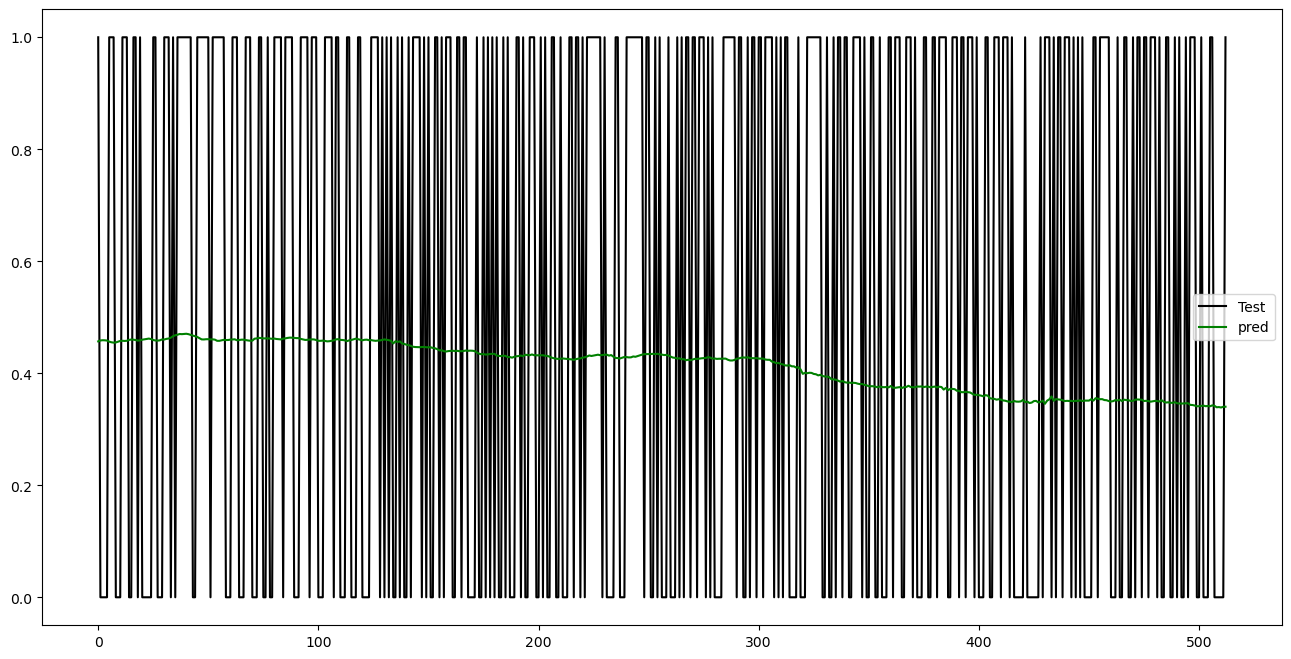

In [305]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()